# Model validation

In [6]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

feynmangpu04.cluster.local
gpu [cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Model

In [102]:
from montecosmo.models import forward_model

# Model params
model_kwargs = {}

## Mesh and box parameters
mesh_length = 64 # 64
box_length = 640 # in Mpc/h (aim for cell lengths between 1 and 10 Mpc/h)
model_kwargs['mesh_size'] = np.array([mesh_length, mesh_length, mesh_length])
model_kwargs['box_size'] = np.array([box_length, box_length, box_length])  # in Mpc/h

## Scale factors
model_kwargs['scale_factor_lpt'] = 0.5
model_kwargs['scale_factor_obs'] = 0.5

## Galaxies
model_kwargs['galaxy_density'] = 1e-3 # in galaxy / (Mpc/h)^3

## Debugging
model_kwargs['trace_reparam'] = True
model_kwargs['trace_deterministic'] = True

cell_lengths=[10.0, 10.0, 10.0] Mpc/h
k_nyquist=0.31416 h/Mpc, delta_k=0.00982 h/Mpc
mean_galaxy_cell_intensity=1.000 galaxy/cell


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


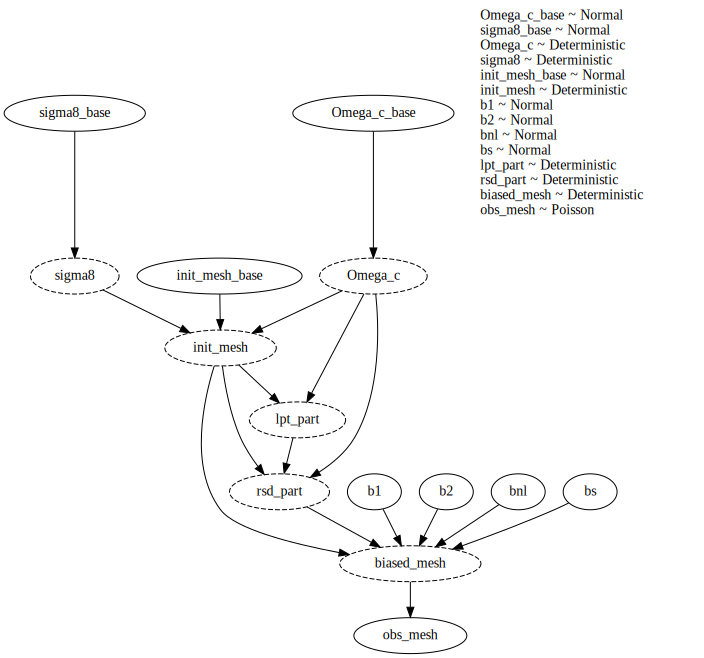

In [103]:
# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.min(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(model=forward_model, model_kwargs=model_kwargs, render_distributions=True, render_params=True)

## Simulate fiducial

In [104]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

# Condition model on some cosmology and sample
fiducial_cosmo_params_base = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, fiducial_cosmo_params_base) # NOTE: Only condition on random sites, not deterministic ones

# Get trace
fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)
# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_model_trace[var_name]['value'] for var_name in cosmo_var_names}
from jax_cosmo import Planck15
fiducial_cosmology = Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


## Power spectra

In [105]:
from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get meshes from model trace
init_mesh = fiducial_model_trace['init_mesh']['value']
biased_mesh = fiducial_model_trace['biased_mesh']['value']
obs_mesh = fiducial_model_trace['obs_mesh']['value']
# Get other meshes from model trace particles, compensate for CIC painting convolution
zeros_mesh = jnp.zeros(model_kwargs['mesh_size'])
lpt_mesh = cic_paint(zeros_mesh, fiducial_model_trace['lpt_part']['value'])
rsd_mesh = cic_paint(zeros_mesh, fiducial_model_trace['rsd_part']['value'])

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
pk_lin_obs = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_obs'])

pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_lpt = power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_rsd = power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_biased = power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


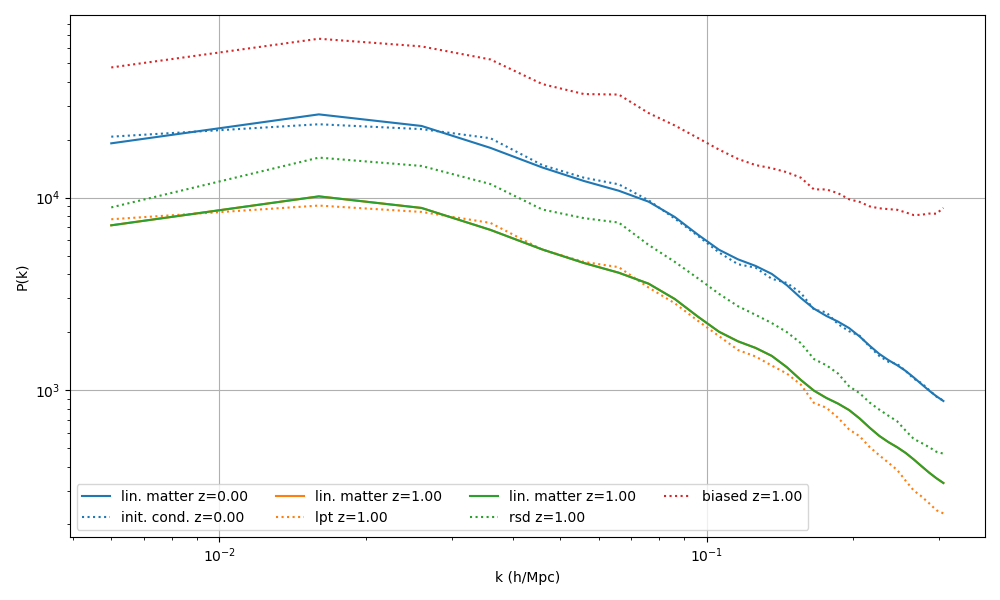

In [106]:
plt.figure(figsize=(10,6))
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), 'C0', label=f"lin. matter z={1/1-1:.2f}")
plt.loglog(pk_init[0], pk_init[1], 'C0:', label=f"init. cond. z={1/1-1:.2f}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), 'C1', label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_lpt[0], pk_lpt[1], 'C1:', label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_init[0], pk_lin_obs(pk_init[0]), 'C2', label=f"lin. matter z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_rsd[0], pk_rsd[1], 'C2:', label=f"rsd z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_biased[0], pk_biased[1], 'C3:', label=f"biased z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.grid(), plt.legend(ncols=4), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.tight_layout(), plt.show();

In [116]:
plt.figure(figsize=(16,4))
# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(131, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("init")

ax3D = plt.subplot(132, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(133, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=obs_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("obs")
# ax3D.set_box_aspect(None, zoom=0.8)

plt.tight_layout(), plt.show();

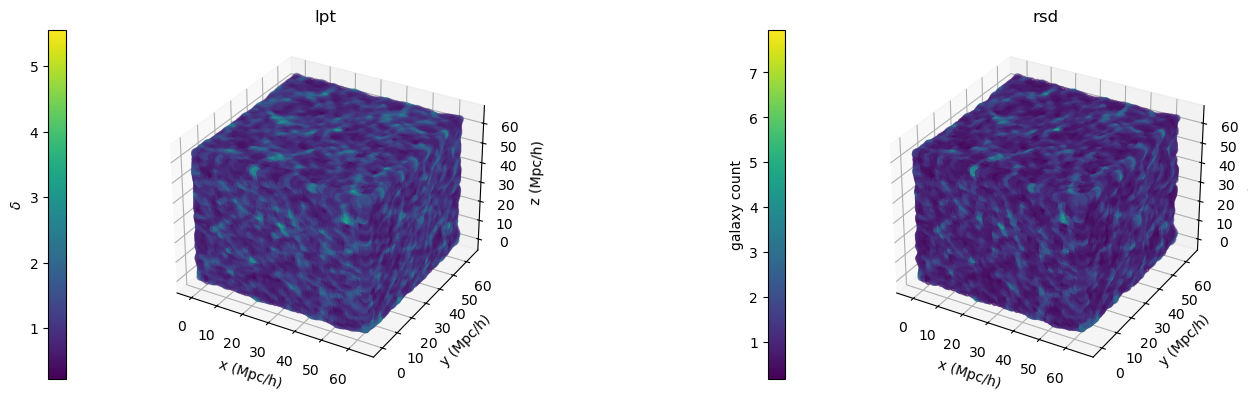

In [113]:
%matplotlib inline
plt.figure(figsize=(16,4))
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(121, projection='3d')
pos = fiducial_model_trace['lpt_part']['value']
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(lpt_mesh, pos))
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(122, projection='3d')
pos = fiducial_model_trace['rsd_part']['value']
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(rsd_mesh, pos))
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("rsd")

plt.tight_layout(), plt.show();